In [1]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model



In [2]:
## Pareto function
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            # print({'proline sink': solution['SK_PRO_c_06'], 'biomass 05': solution['Leaf_biomass_tx_05'], 'biomass 06': solution['Leaf_biomass_tx_06']})
            # solution.fluxes.to_excel(f'pareto_no_{pareto}.xlsx')
            result_list.append([pareto, solution[objective1], solution[objective2]])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    return result_list

In [3]:
model_rs = read_sbml_model('/Users/subasrees/Desktop/Core_Model_Simulations/beta_day_RS_DM_new.xml')
core_model=model_rs

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-16


In [4]:
##Constraints
rubisco = core_model.problem.Constraint(3 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
core_model.add_cons_vars([rubisco])
## 
atp = core_model.problem.Constraint((0.0049*core_model.reactions.get_by_id("Photon_tx").flux_expression+2.7851)-core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp)
##
atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)

In [5]:
## Add demand metabolites for all non-enzymatic antioxidants
core_model.add_metabolites([
    Metabolite(
    'GLUTATHIONE_cell',
    name='GLUTATHIONE',
    compartment='cell',
    formula='C10H16N3O6S',
    charge=-1
    ),
    Metabolite('ASCORBATE_cell',
    name='ASCORBATE',
    compartment='cell',
    formula='C6H7O6',
    charge=-1
    ),
    Metabolite('L_DEHYDRO_ASCORBATE_cell',
    name='L_DEHYDRO_ASCORBATE',
    compartment='cell',
    formula='C6H5O6',
    charge=-1
    ),
    Metabolite('OXIDIZED_GLUTATHIONE_cell',
    name='OXIDIZED_GLUTATHIONE',
    compartment='cell',
    formula='C20H30N6O12S2',
    charge=-2
    )
    ])

In [6]:
## Glutathione
reaction = Reaction('Glutathione_p_demand')
reaction.name = 'GLUTATHIONE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_p'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('Glutathione_n_demand')
reaction.name = 'GLUTATHIONE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_n'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('Glutathione_m_demand')
reaction.name = 'GLUTATHIONE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_m'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_x_demand')
reaction.name = 'GLUTATHIONE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_x'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_e_demand')
reaction.name = 'GLUTATHIONE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('GLUTATHIONE_e'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_c_demand')
reaction.name = 'GLUTATHIONE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('GLUTATHIONE_c'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
#
reaction = Reaction('Glutathione_v_demand')
reaction.name = 'GLUTATHIONE vacuolar demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_v'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

GLUTATHIONE_p --> GLUTATHIONE_cell
GLUTATHIONE_n --> GLUTATHIONE_cell
GLUTATHIONE_m --> GLUTATHIONE_cell
GLUTATHIONE_x --> GLUTATHIONE_cell
GLUTATHIONE_e --> GLUTATHIONE_cell
GLUTATHIONE_c --> GLUTATHIONE_cell
GLUTATHIONE_v --> GLUTATHIONE_cell


In [7]:
## OXIDIZED_GLUTATHIONE
reaction = Reaction('OXIDIZED_GLUTATHIONE_p_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_p'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_n_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_n'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_m_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_m'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_x_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_x'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_e_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('OXIDIZED_GLUTATHIONE_e'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_c_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('OXIDIZED_GLUTATHIONE_c'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])


OXIDIZED_GLUTATHIONE_p --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_n --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_m --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_x --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_e --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_c --> OXIDIZED_GLUTATHIONE_cell


In [8]:
## ASCORBATE
reaction = Reaction('ASCORBATE_p_demand')
reaction.name = 'ASCORBATE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_p'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('ASCORBATE_n_demand')
reaction.name = 'ASCORBATE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_n'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('ASCORBATE_m_demand')
reaction.name = 'ASCORBATE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_m'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_x_demand')
reaction.name = 'ASCORBATE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_x'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_e_demand')
reaction.name = 'ASCORBATE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('ASCORBATE_e'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_c_demand')
reaction.name = 'ASCORBATE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('ASCORBATE_c'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_v_demand')
reaction.name = 'ASCORBATE vacuolar demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_v'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_g_demand')
reaction.name = 'ASCORBATE glyoxysome demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_g'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

ASCORBATE_p --> ASCORBATE_cell
ASCORBATE_n --> ASCORBATE_cell
ASCORBATE_m --> ASCORBATE_cell
ASCORBATE_x --> ASCORBATE_cell
ASCORBATE_e --> ASCORBATE_cell
ASCORBATE_c --> ASCORBATE_cell
ASCORBATE_v --> ASCORBATE_cell
ASCORBATE_g --> ASCORBATE_cell


In [9]:
## L_DEHYDRO_ASCORBATE
reaction = Reaction('L_DEHYDRO_ASCORBATE_p_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_p'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_n_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_n'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_m_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_m'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_x_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_x'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_e_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('L_DEHYDRO_ASCORBATE_e'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_c_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('L_DEHYDRO_ASCORBATE_c'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_g_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE glyoxysome demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_g'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

L_DEHYDRO_ASCORBATE_p --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_n --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_m --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_x --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_e --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_c --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_g --> L_DEHYDRO_ASCORBATE_cell


In [10]:
core_model.add_boundary(core_model.metabolites.get_by_id("L_DEHYDRO_ASCORBATE_cell"), type="demand")
core_model.reactions.get_by_id('DM_L_DEHYDRO_ASCORBATE_cell').bounds=(0.0041,1000)

core_model.add_boundary(core_model.metabolites.get_by_id("ASCORBATE_cell"), type="demand")
core_model.reactions.get_by_id('DM_ASCORBATE_cell').bounds=(0.0088,1000) 

core_model.add_boundary(core_model.metabolites.get_by_id("GLUTATHIONE_cell"), type="demand")
core_model.reactions.get_by_id('DM_GLUTATHIONE_cell').bounds=(0.003,1000)

core_model.add_boundary(core_model.metabolites.get_by_id("OXIDIZED_GLUTATHIONE_cell"), type="demand")
core_model.reactions.get_by_id('DM_OXIDIZED_GLUTATHIONE_cell').bounds=(0.00083,1000)

In [11]:
# constraint only the flux active superoxide dismutase
#core_model.reactions.get_by_id('RS_Plant_SOD_X').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_M').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_A').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_N').bounds=(7.5,1000)
#core_model.reactions.get_by_id('RS_Plant_SOD_V').bounds=(7.5,1000) loop
core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_p').bounds=(7.490005839,1000)#7.490005839 0.4880487805
core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_c').bounds=(7.490005839,1000)#7.490005839 0.4880487805

In [12]:
# constraint only the flux active catalase
core_model.reactions.get_by_id('CATAL_RXN_x').bounds=(2.178502448,1000)
core_model.reactions.get_by_id('RS_Plant_CAT_M').bounds=(2.178502448,1000)

# constraint only the flux active peroxidase
#core_model.reactions.get_by_id('RS_Plant_Per3_V').bounds=(9.461943584,1000)

## constraint only the flux active ascorbate peroxidase
#core_model.reactions.get_by_id('L_ASCORBATE_PEROXIDASE_RXN_m').bounds=(31.04927458,1000)
#core_model.reactions.get_by_id('L_ASCORBATE_PEROXIDASE_RXN_p').bounds=(31.04927458,1000)
#core_model.reactions.get_by_id('RXN_3521_p').bounds=(31.04927458,1000)
#core_model.reactions.get_by_id('RS_Plant_APX_X').bounds=(0,31.05)
#core_model.reactions.get_by_id('RS_Plant_APX_C').bounds=(0,31.05)#loop
#core_model.reactions.get_by_id('RS_Plant_APX_A').bounds=(0,31.05)
#core_model.reactions.get_by_id('RS_Plant_APX_G').bounds=(0,31.05)

## save the models
#beta_antiox_dm=core_model
#write_sbml_model(beta_antiox_dm,'beta_antiox_dm.xml')



In [13]:
sol = core_model.optimize()
print(core_model.summary(sol))

Objective
1.0 AraCore_Biomass_tx = 314.3735985254766

Uptake
------
      Metabolite   Reaction    Flux  C-Number  C-Flux
CARBON_DIOXIDE_e     CO2_tx   11.98         1 100.00%
          CAII_e      Ca_tx  0.1205         0   0.00%
         WATER_e     H2O_tx   25.47         0   0.00%
            KI_e       K_tx  0.2464         0   0.00%
          MGII_e      Mg_tx 0.07939         0   0.00%
       NITRATE_e Nitrate_tx   1.055         0   0.00%
        Photon_e  Photon_tx     300         0   0.00%
            Pi_e      Pi_tx 0.04826         0   0.00%
       SULFATE_e     SO4_tx 0.01954         0   0.00%

Secretion
---------
               Metabolite                     Reaction     Flux  C-Number C-Flux
           ASCORBATE_cell            DM_ASCORBATE_cell  -0.0088         6 42.58%
         GLUTATHIONE_cell          DM_GLUTATHIONE_cell   -0.003        10 24.19%
   HYDROGEN_PEROXIDE_cell    DM_HYDROGEN_PEROXIDE_cell   -15.22         0  0.00%
 L_DEHYDRO_ASCORBATE_cell  DM_L_DEHYDRO_ASCORBA


Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 96.54247182066665

Solving all iterations for Pareto frontier (FBA)...
        0          1           2
0    0.00  14.975912  314.373599
1    0.01  14.975912  314.373599
2    0.02  14.975912  314.373599
3    0.03  14.975912  314.373599
4    0.04  14.975912  314.373599
..    ...        ...         ...
96   0.96  92.680773   15.821826
97   0.97  93.646198   11.866369
98   0.98  94.611622    7.910913
99   0.99  95.577047    3.955456
100  1.00  96.542472    0.000000

[101 rows x 3 columns]


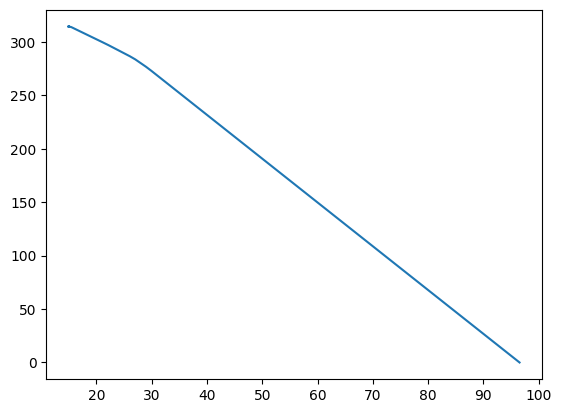

In [14]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'#Arabidopsis_biomass_tx AraCore_Biomass_tx
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')
data=pd.DataFrame(solution_primary)
print(data)
plt.plot(data[1],data[2]) 
plt.show()
###objs_rs=[AraCore_Biomass_tx 'Phloem_output_tx',DM_OOH-_cell 'DM_NITRIC-OXIDE_cell','DM_HS_cell','DM_SUPER_OXIDE_cell','DM_HC00250_cell','DM_CPD0-1395_cell','DM_SO3_cell','DM_CPD-12377_cell','DM_HYDROGEN_PEROXIDE_cell','DM_ho2_rad_cell']
